In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from utils import tangent_space_cov, optimal_cpd_rank, get_tssa_train_fc, tssa_cov_split
from tSSA import t_SSA
from journal_style import EnableJournalStylePlotting
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.distance import distance_riemann
from multimodel import LocalModel, LocalMultiModel
from causal_ccm import ccm
import pyEDM
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests

In [64]:
def func_1(A, B, r, beta):
    return A * (r - r * A - beta * B)

# params
r_x = 3.8
r_y = 3.5
B_xy = 0 # effect on x given y (effect of y on x)
B_yx = 0 # effect on y given x (effect of x on y)

X0 = 0.4 # initial val
Y0 = 0.6 # initial val
t = 5000 # time steps

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = func_1(X[-1], Y[-1], r_x, B_xy)
    Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_) 

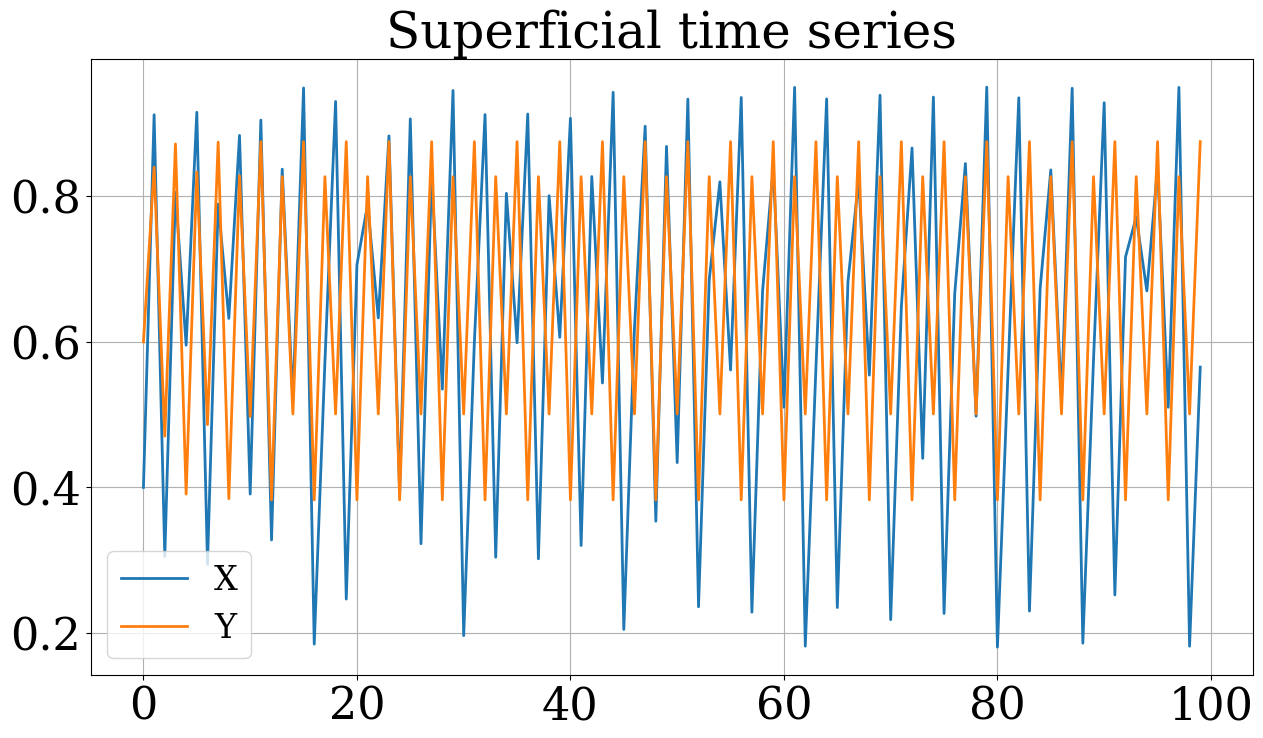

In [65]:
with EnableJournalStylePlotting():
    fig, ax = plt.subplots(figsize=(15, 8))

    ax.plot(X[:100], label='X')
    ax.plot(Y[:100], label='Y')

    ax.grid(True)
    ax.legend()

    ax.tick_params(axis='x', labelsize=32)
    ax.tick_params(axis='y', labelsize=32)
    #ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
    ax.set_title(r"Superficial time series")
    
    plt.show()

In [66]:
ts = np.concatenate([np.reshape(X, (len(X), 1)), np.reshape(Y, (len(Y), 1))], axis=1)

train_ts = ts[:ts.shape[0] - 250, :]
test_ts = ts[ts.shape[0] - 250:, :]

## Выбор количества ближайших соседей и размерности вложения

In [67]:
# let's define a number of possible embeddings/projections/dimensions
embeds = np.arange(1,11)

# output metrics for each embedding value
MAE = [] # Mean Absolute Error
rho = [] # Pearson correlation
RMSE = [] # Root-Mean Square Error

for e in embeds:
  simplex_result = pyEDM.Simplex(dataFrame=pd.DataFrame(train_ts[:, 0]), E=e, lib="1 1000" , pred="1001 1200" , columns=[0], target=[0])
  metrics = pyEDM.ComputeError(simplex_result.Observations, simplex_result.Predictions)
  MAE.append(metrics['MAE'])
  rho.append(metrics['rho'])
  RMSE.append(metrics['RMSE'])

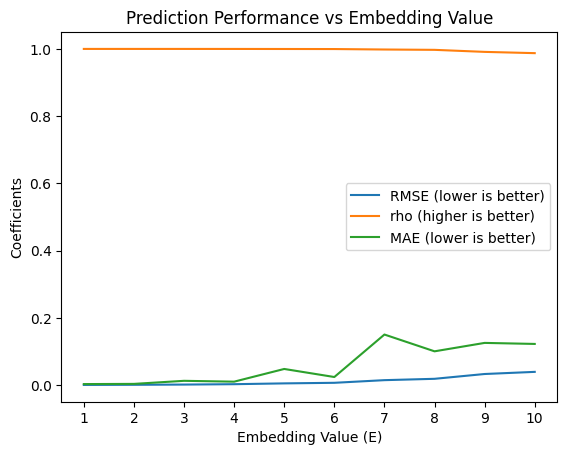

In [68]:
pd.Series(RMSE).plot(label='RMSE (lower is better)') 
pd.Series(rho).plot(label='rho (higher is better)') 
pd.Series(MAE).plot(label='MAE (lower is better)') 

x = np.arange(10)
plt.xticks(x, embeds)
plt.xlabel('Embedding Value (E)')
plt.ylabel('Coefficients')
plt.legend(loc='best')
plt.title("Prediction Performance vs Embedding Value")
plt.show()

In [69]:
k = 3
L = 2
h = test_ts.shape[0]

In [70]:
loc_model = LocalModel(k, L)

In [71]:
loc_forecater = LocalModel(k, L).fit(train_ts)
loc_preds = loc_forecater.predict(h)

In [72]:
mae_output = loc_forecater.mae(test_ts)

MAE: 0.26104156240461057
MAE: 2.0872192862952943e-17
Mean by signals: MAE = 0.13052078120230529


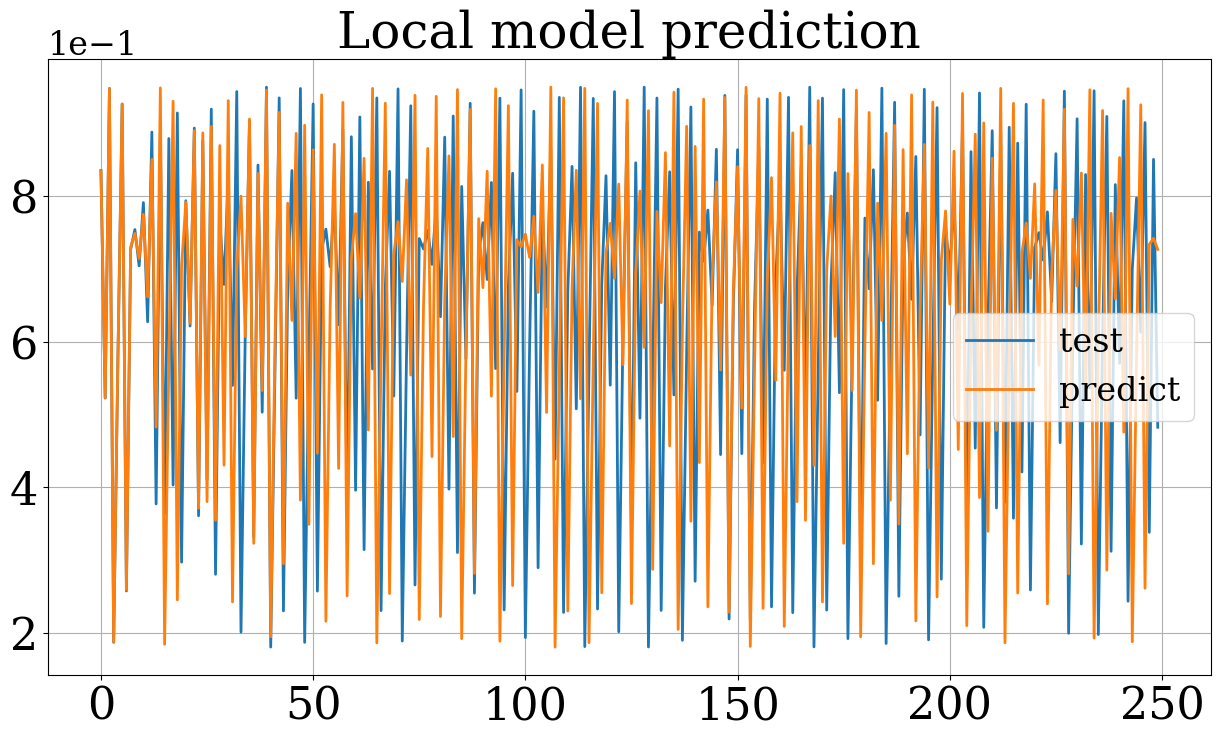

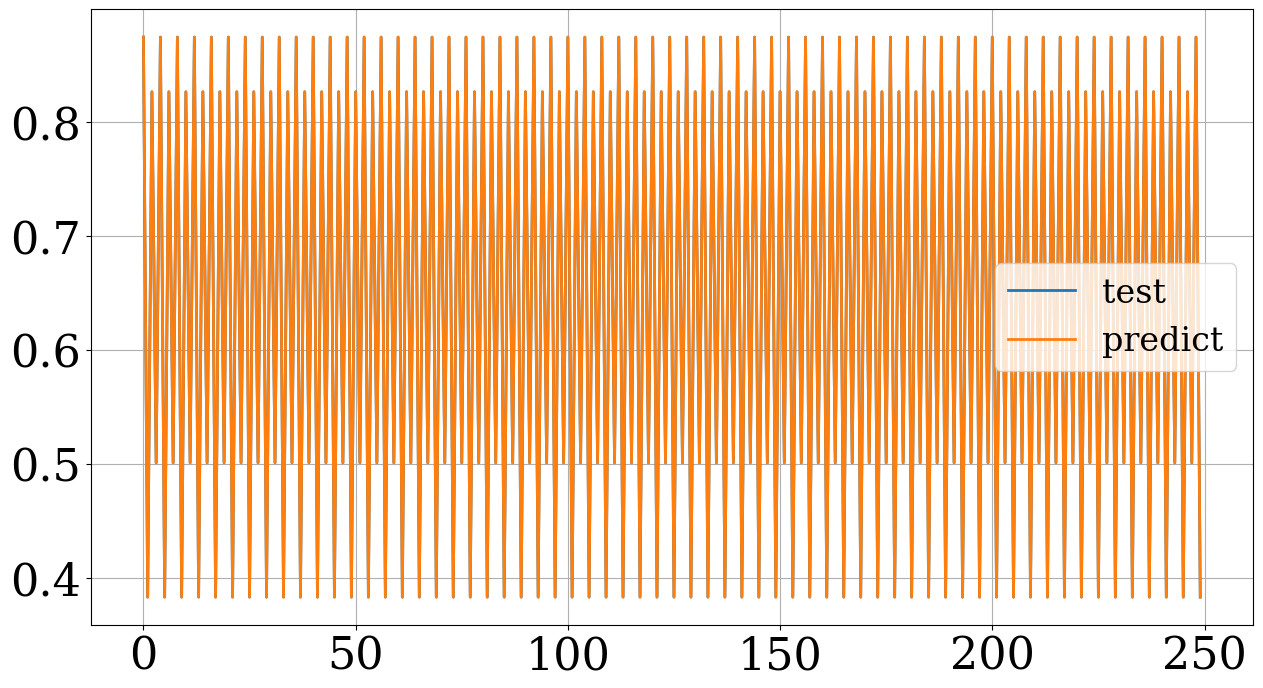

In [73]:
loc_forecater.plot_pred(test_ts)

# Local Multimodel

In [74]:
h_range = [h // i for i in range(4, 1, -1)] + [h + 100 * i for i in range(7)]

In [75]:
print(h_range)

[62, 83, 125, 250, 350, 450, 550, 650, 750, 850]


In [76]:
loc_multimodels = {h_i: [LocalMultiModel(L, loc_model, LinearRegression(), 'scm').fit(train_ts, h=h_i)] for h_i in h_range}

g: 62, f: 62
g: 83, f: 83
g: 125, f: 125
g: 250, f: 250
g: 350, f: 350
g: 450, f: 450
g: 550, f: 550
g: 650, f: 650
g: 750, f: 750
g: 850, f: 850


In [77]:
for key in loc_multimodels:
    output = loc_multimodels[key][-1].F_quality()
    loc_multimodels[key].append(output)

In [78]:
multi_mean_train_mse = []
local_mean_train_mse = []
multi_mean_test_mse = []
local_mean_test_mse = []

for key in loc_multimodels:
    multi_mean_train_mse.append(loc_multimodels[key][1]['train_mean'][0])
    local_mean_train_mse.append(loc_multimodels[key][1]['local_train_mean'][0])
    multi_mean_test_mse.append(loc_multimodels[key][1]['test_mean'][0])
    local_mean_test_mse.append(loc_multimodels[key][1]['local_test_mean'][0])

In [79]:
print(np.array(multi_mean_test_mse))

[0.01287624 0.03050779 0.02697223 0.03019763 0.02984363 0.02871476
 0.03071601 0.03049815 0.03195179 0.0305654 ]


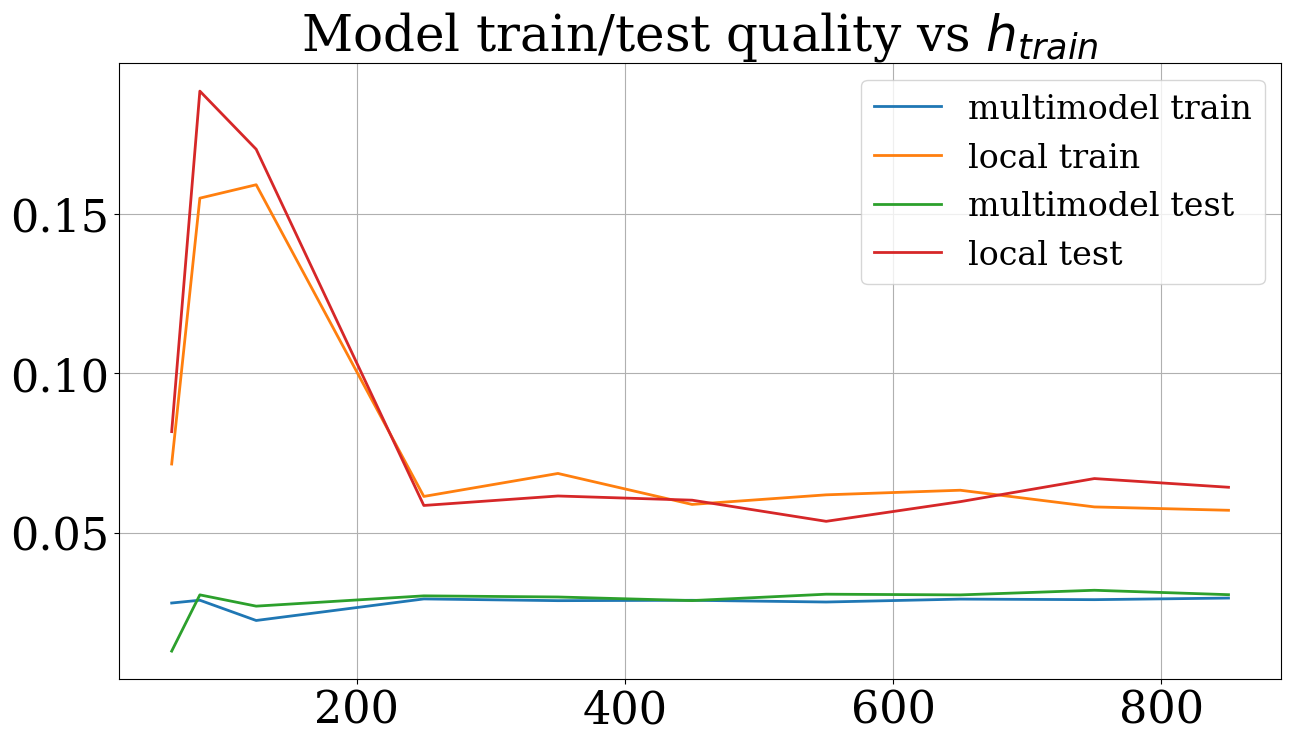

In [80]:
with EnableJournalStylePlotting():
    fig, ax = plt.subplots(figsize=(15, 8))

    ax.plot(h_range, multi_mean_train_mse, label='multimodel train')
    ax.plot(h_range, local_mean_train_mse, label='local train')
    ax.plot(h_range, multi_mean_test_mse, label='multimodel test')
    ax.plot(h_range, local_mean_test_mse, label='local test')

    ax.grid(True)
    ax.legend()

    ax.tick_params(axis='x', labelsize=32)
    ax.tick_params(axis='y', labelsize=32)
    #ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
    ax.set_title(r"Model train/test quality vs $h_{train}$")
    
    plt.show()

_____________________________________________________________________________________________________________________________________________

# Проверка стационарности векторов касательного пространства

In [22]:
def kpss_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
    for c in data_df.columns: 
        kpss_res = kpss(data_df[c].dropna(), regression='ct')
        test_stat.append(kpss_res[0])
        p_val.append(kpss_res[1])
        cv_1pct.append(kpss_res[3]['1%'])
        cv_2p5pct.append(kpss_res[3]['2.5%'])
        cv_5pct.append(kpss_res[3]['5%'])
        cv_10pct.append(kpss_res[3]['10%'])
    kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 2.5%': cv_2p5pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data_df.columns).T
    kpss_res_df = kpss_res_df.round(4)
    return kpss_res_df

In [23]:
def adf_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_5pct, cv_10pct = [], [], []
    for c in data_df.columns: 
        adf_res = adfuller(data_df[c].dropna())
        test_stat.append(adf_res[0])
        p_val.append(adf_res[1])
        cv_1pct.append(adf_res[4]['1%'])
        cv_5pct.append(adf_res[4]['5%'])
        cv_10pct.append(adf_res[4]['10%'])
    adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data_df.columns).T
    adf_res_df = adf_res_df.round(4)
    return adf_res_df

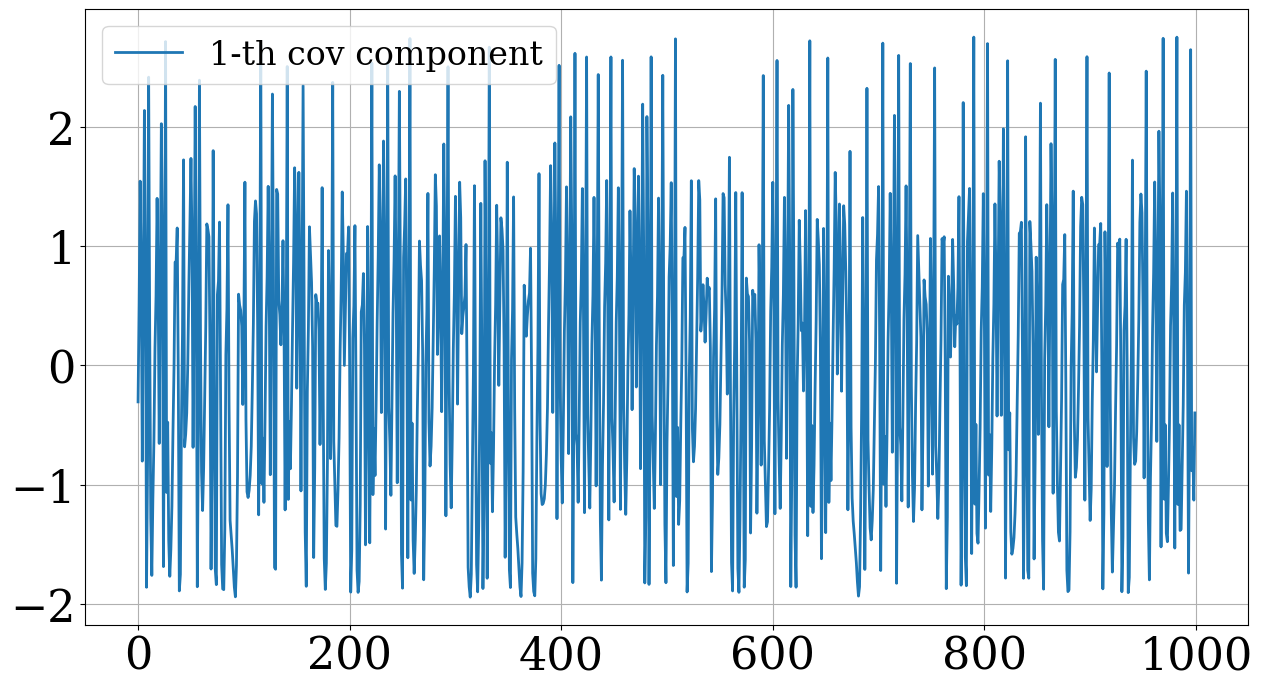

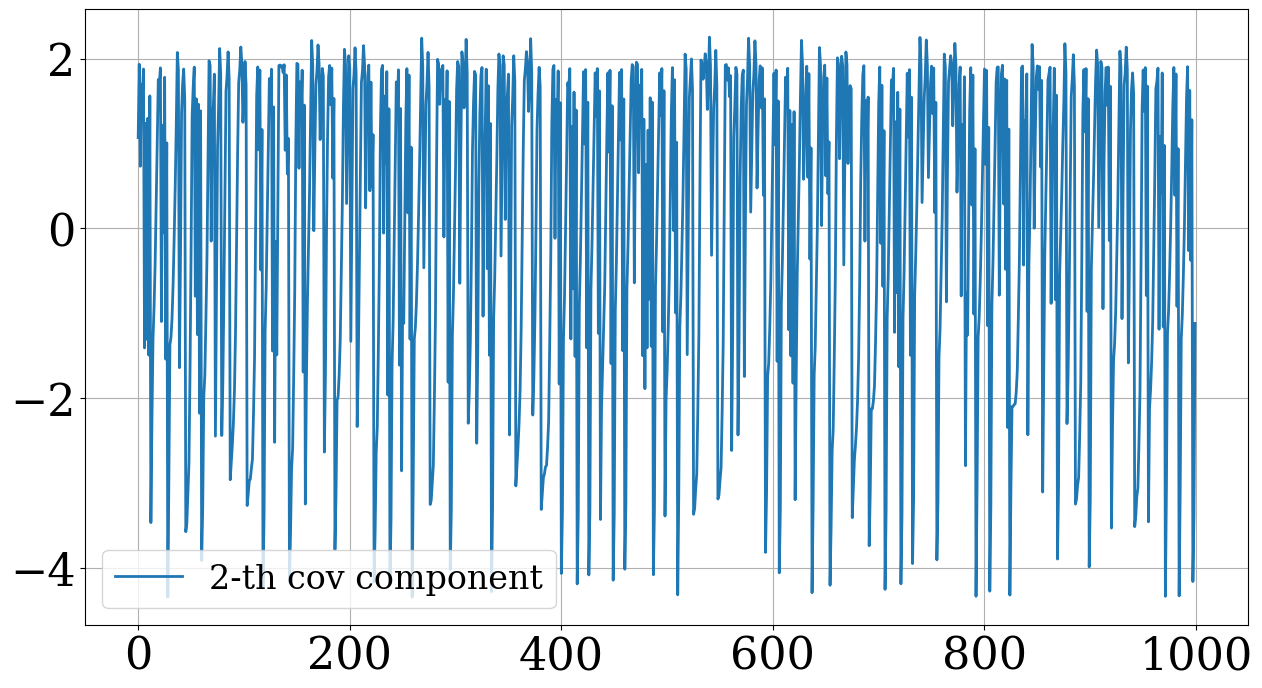

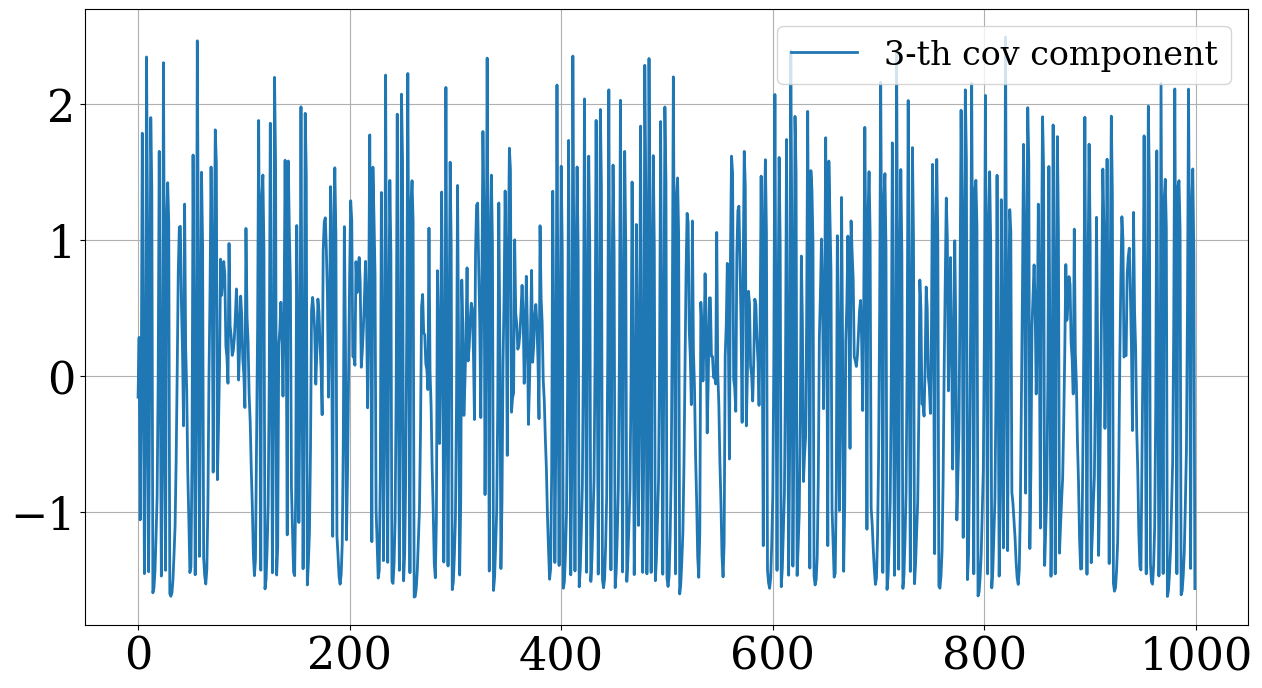

In [24]:
vectorized_cov = loc_multimodels[250][0].tgt_cov_ts

for i in range(vectorized_cov.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(15, 8))

        ax.plot(vectorized_cov[:1000, :].T[i], label=f'{i + 1}-th cov component')

        ax.grid(True)
        ax.legend()

        ax.tick_params(axis='x', labelsize=32)
        ax.tick_params(axis='y', labelsize=32)
        if i == 0:
            ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
            # ax.set_title('F model prediction')

plt.show()

In [25]:
kpss_test(pd.DataFrame(vectorized_cov))

/tmp/ipykernel_1323164/4241934693.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(data_df[c].dropna(), regression='ct')
/tmp/ipykernel_1323164/4241934693.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(data_df[c].dropna(), regression='ct')
/tmp/ipykernel_1323164/4241934693.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(data_df[c].dropna(), regression='ct')


0       1       2
Test statistic         0.0223  0.0876  0.0154
p-value                0.1000  0.1000  0.1000
Critical value - 1%    0.2160  0.2160  0.2160
Critical value - 2.5%  0.1760  0.1760  0.1760
Critical value - 5%    0.1460  0.1460  0.1460
Critical value - 10%   0.1190  0.1190  0.1190

In [26]:
adf_test(pd.DataFrame(vectorized_cov))

0        1        2
Test statistic       -14.1027 -16.2538 -17.3228
p-value                0.0000   0.0000   0.0000
Critical value - 1%   -3.4317  -3.4317  -3.4317
Critical value - 5%   -2.8622  -2.8622  -2.8622
Critical value - 10%  -2.5671  -2.5671  -2.5671

______________________________________________________________________________________________________________________________________________

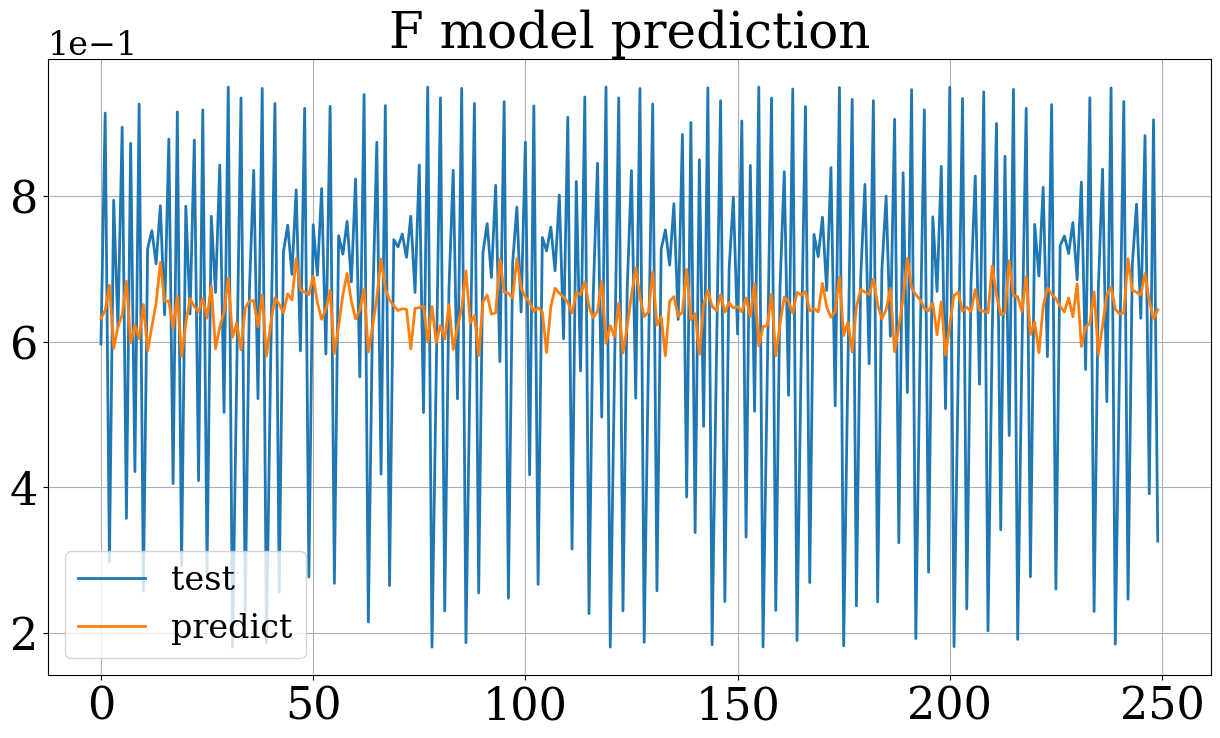

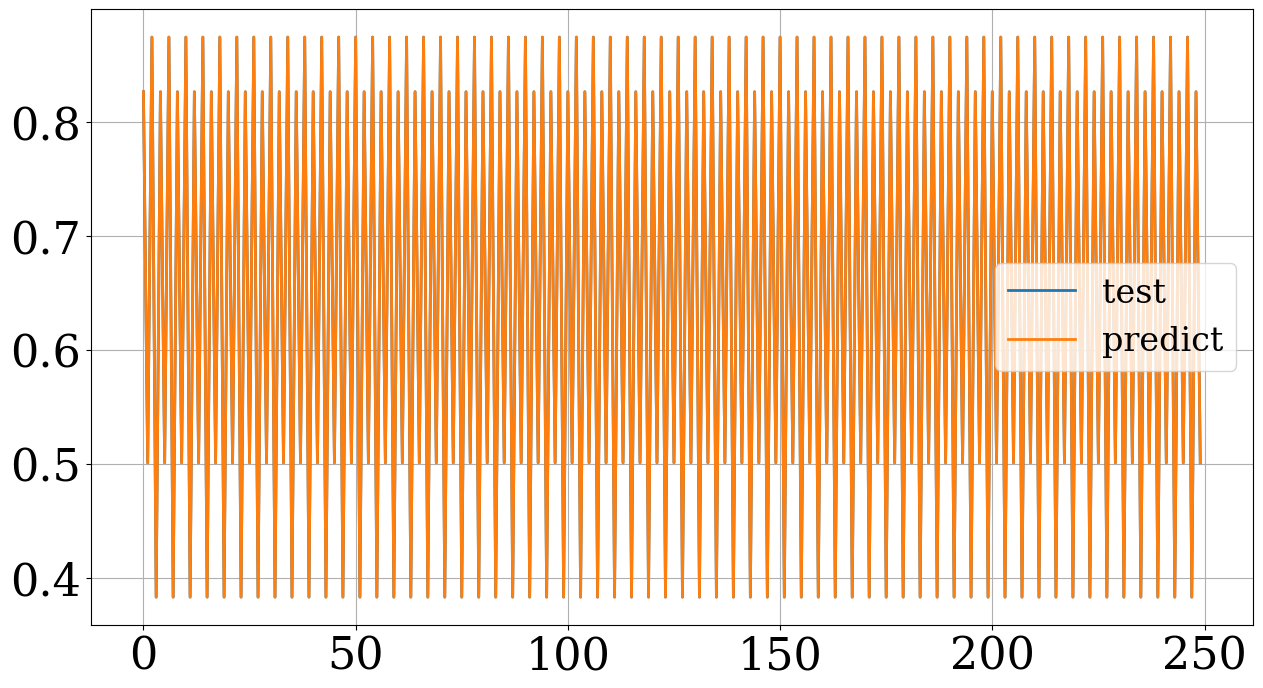

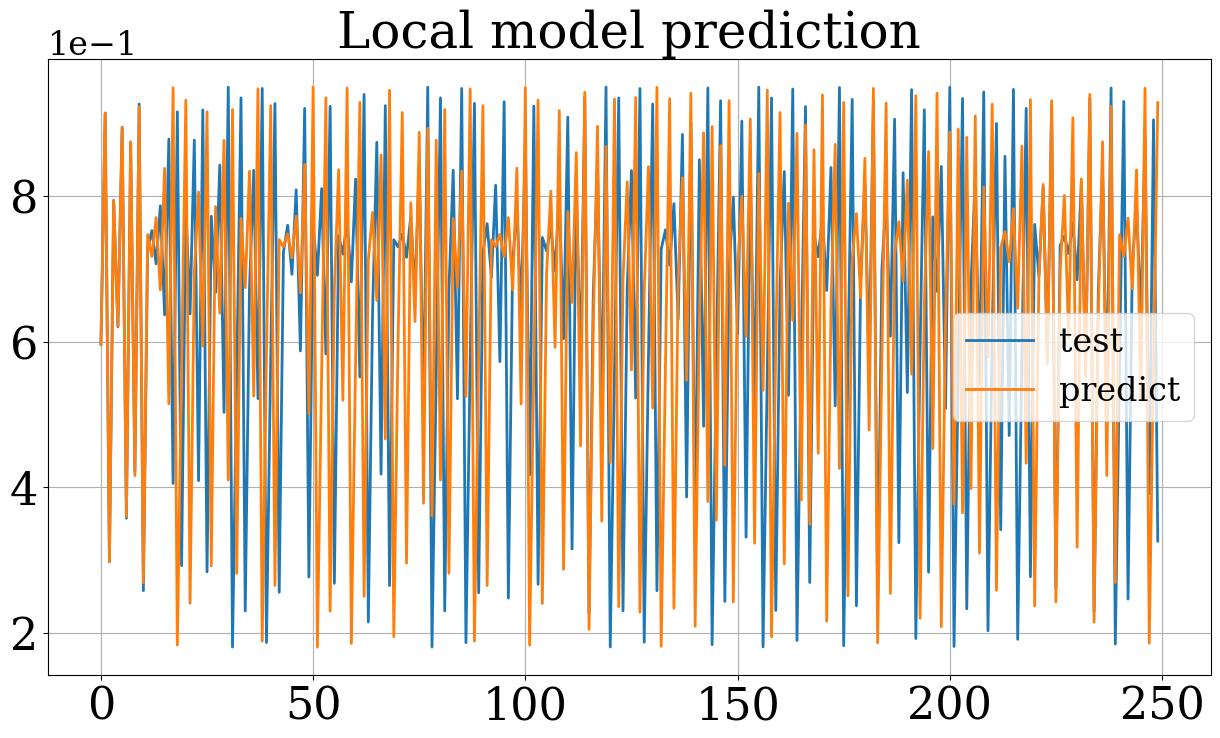

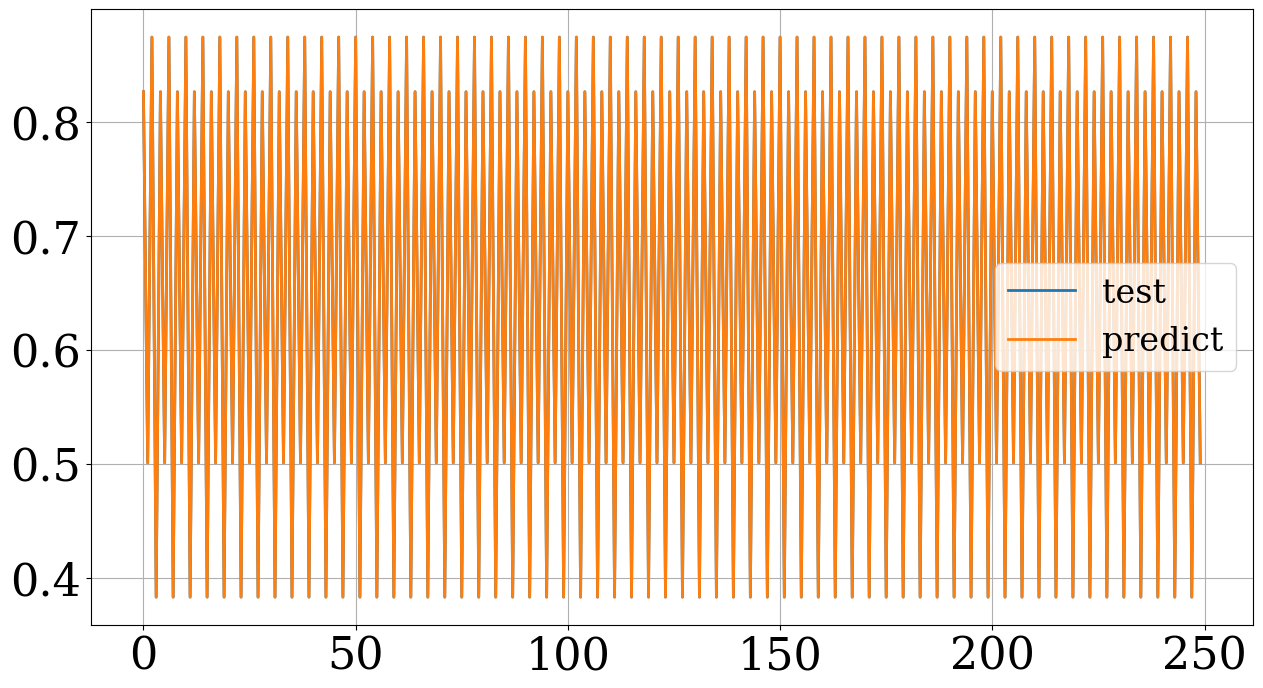

In [81]:
loc_multimodels[250][0].plot_fit_pred()

In [83]:
test_preds = loc_multimodels[250][0].predict(h)

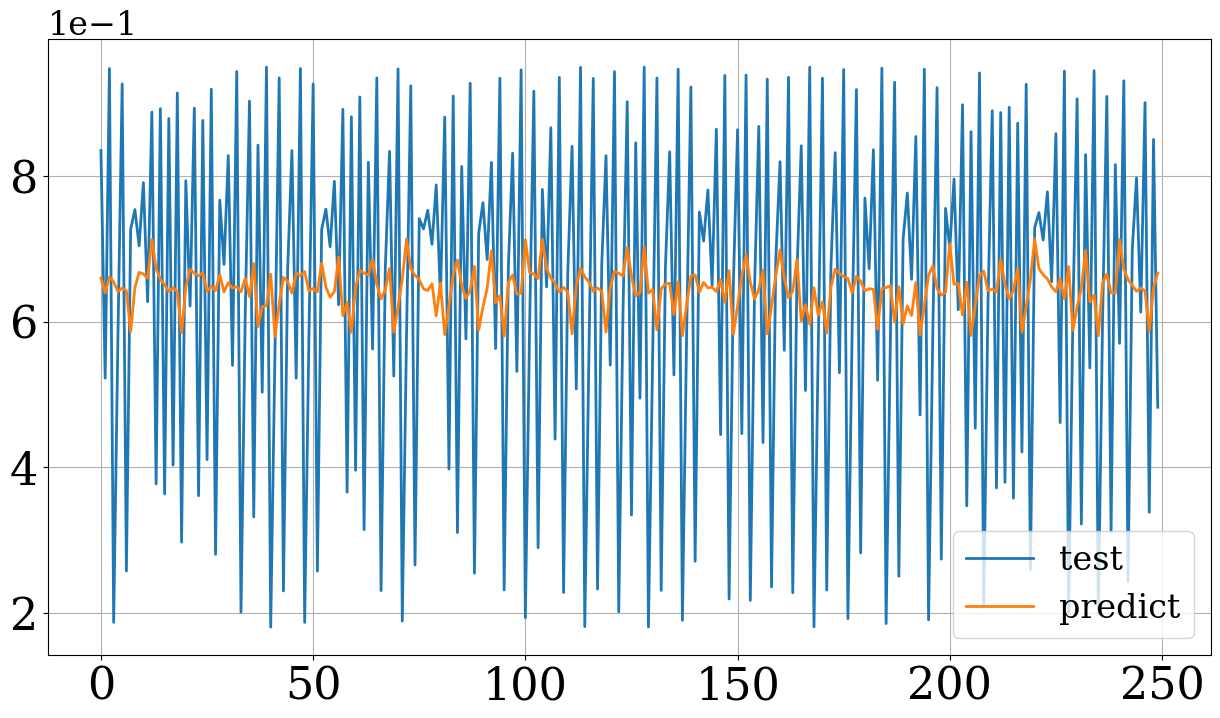

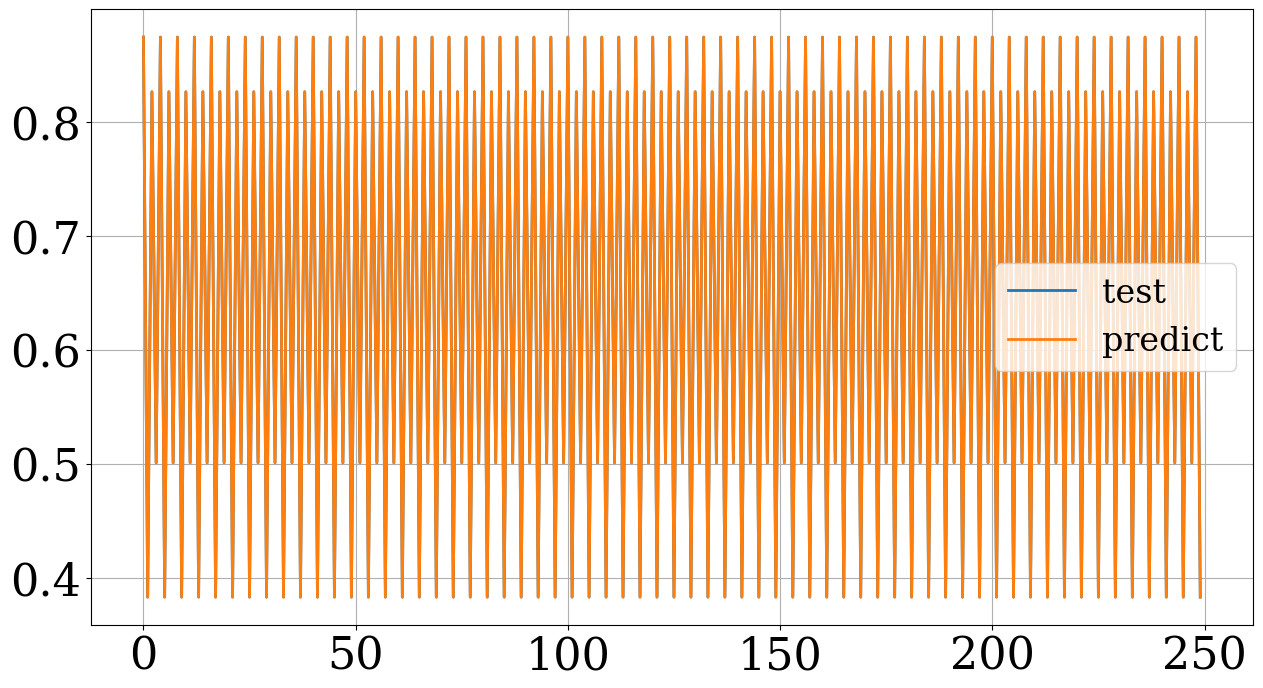

In [84]:
for i in range(test_ts.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(15, 8))

        ax.plot(test_ts.T[i], label='test')
        ax.plot(test_preds.T[i], label='predict')

        ax.grid(True)
        ax.legend()

        ax.tick_params(axis='x', labelsize=32)
        ax.tick_params(axis='y', labelsize=32)
        if i == 0:
            ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
            # ax.set_title('F model prediction')

plt.show()

In [85]:
print(np.mean(np.abs(test_preds - test_ts), axis=0))
print(np.mean(np.mean(np.abs(test_preds - test_ts), axis=0)))

[2.15094380e-01 3.53717056e-16]
0.10754719019339237


### Without correlations

In [86]:
loc_multimodels_nocov = {h_i: [LocalMultiModel(L, loc_model, LinearRegression(), 'scm').fit(train_ts, h=h_i, cov_use=False)] for h_i in h_range}

In [87]:
for key in loc_multimodels_nocov:
    output = loc_multimodels_nocov[key][-1].F_quality()
    loc_multimodels_nocov[key].append(output)

In [88]:
multi_nocov_mean_train_mse = []
local_nocov_mean_train_mse = []
multi_nocov_mean_test_mse = []
local_nocov_mean_test_mse = []

for key in loc_multimodels_nocov:
    multi_nocov_mean_train_mse.append(loc_multimodels_nocov[key][1]['train_mean'][0])
    local_nocov_mean_train_mse.append(loc_multimodels_nocov[key][1]['local_train_mean'][0])
    multi_nocov_mean_test_mse.append(loc_multimodels_nocov[key][1]['test_mean'][0])
    local_nocov_mean_test_mse.append(loc_multimodels_nocov[key][1]['local_test_mean'][0])

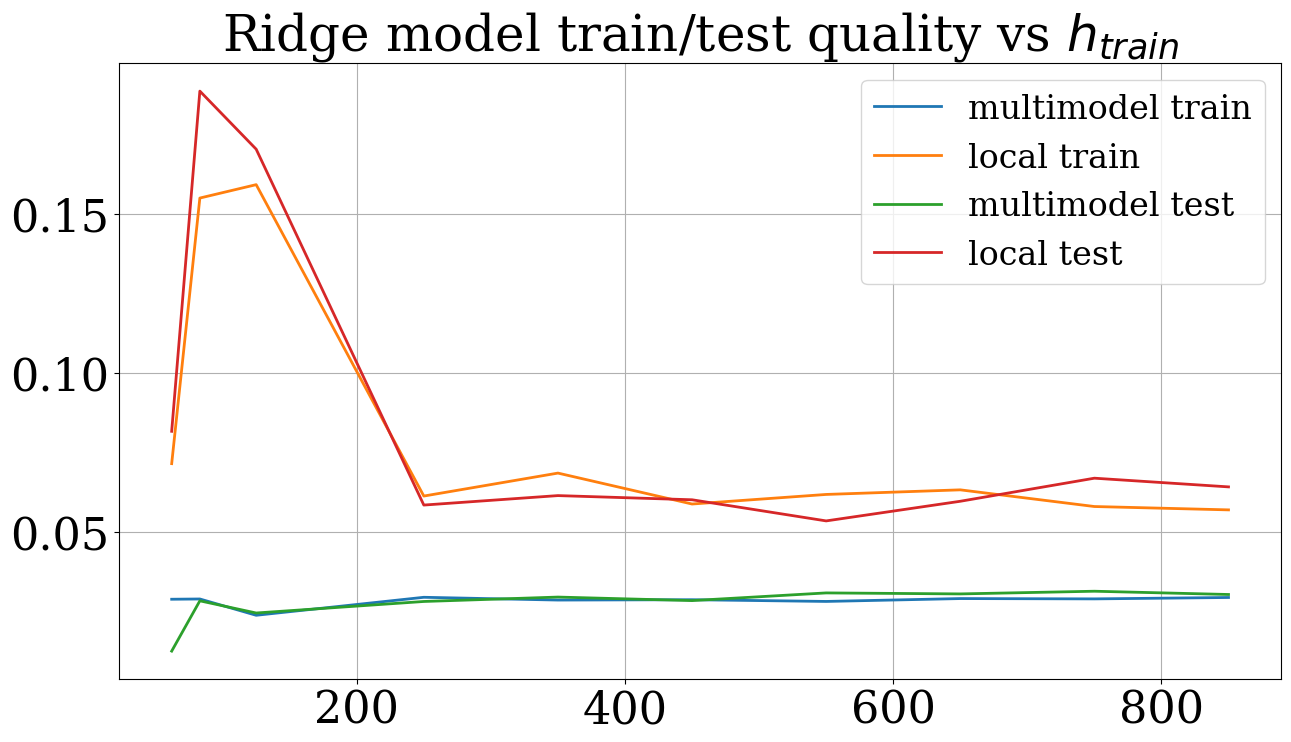

In [89]:
with EnableJournalStylePlotting():
    fig, ax = plt.subplots(figsize=(15, 8))

    ax.plot(h_range, multi_nocov_mean_train_mse, label='multimodel train')
    ax.plot(h_range, local_nocov_mean_train_mse, label='local train')
    ax.plot(h_range, multi_nocov_mean_test_mse, label='multimodel test')
    ax.plot(h_range, local_nocov_mean_test_mse, label='local test')

    ax.grid(True)
    ax.legend()

    ax.tick_params(axis='x', labelsize=32)
    ax.tick_params(axis='y', labelsize=32)
    #ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
    ax.set_title(r"Ridge model train/test quality vs $h_{train}$")
    
    plt.show()

In [91]:
params_nocov = loc_multimodels_nocov[250][0].F_model.coef_
print(params_nocov)

[[-4.21977425e-03  1.24100674e-02]
 [-1.12748101e-17  2.09342962e-01]]


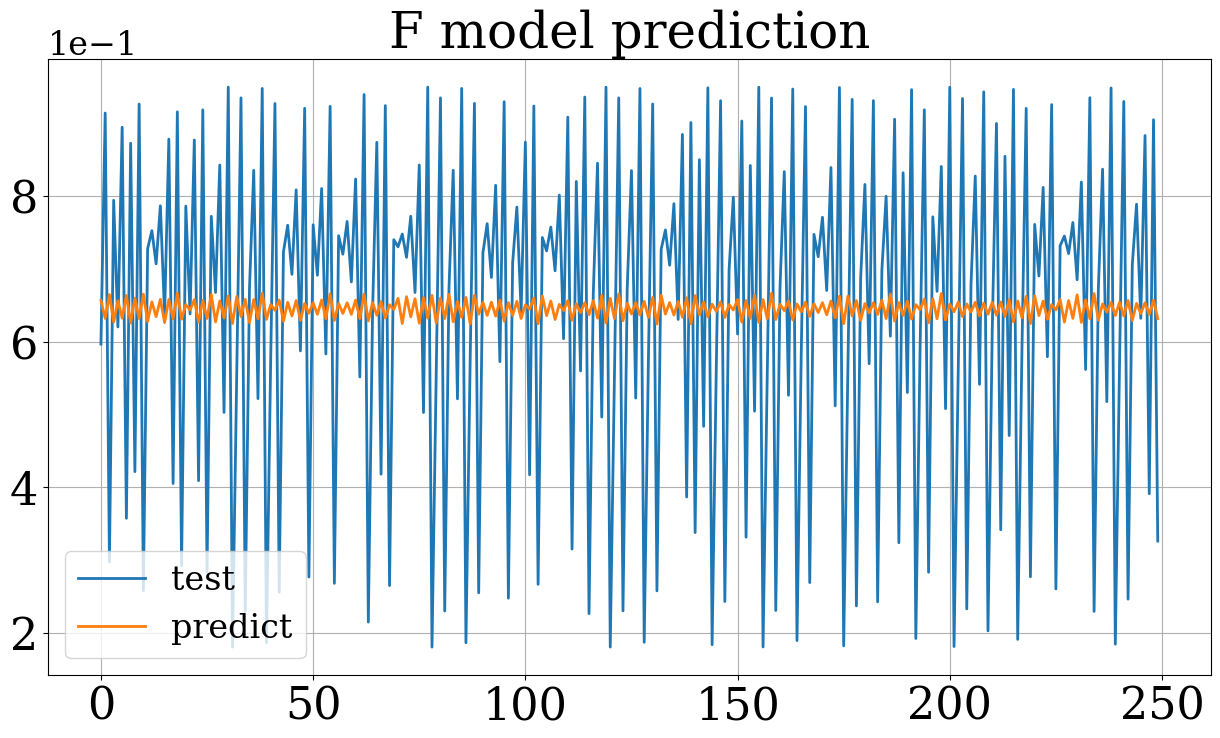

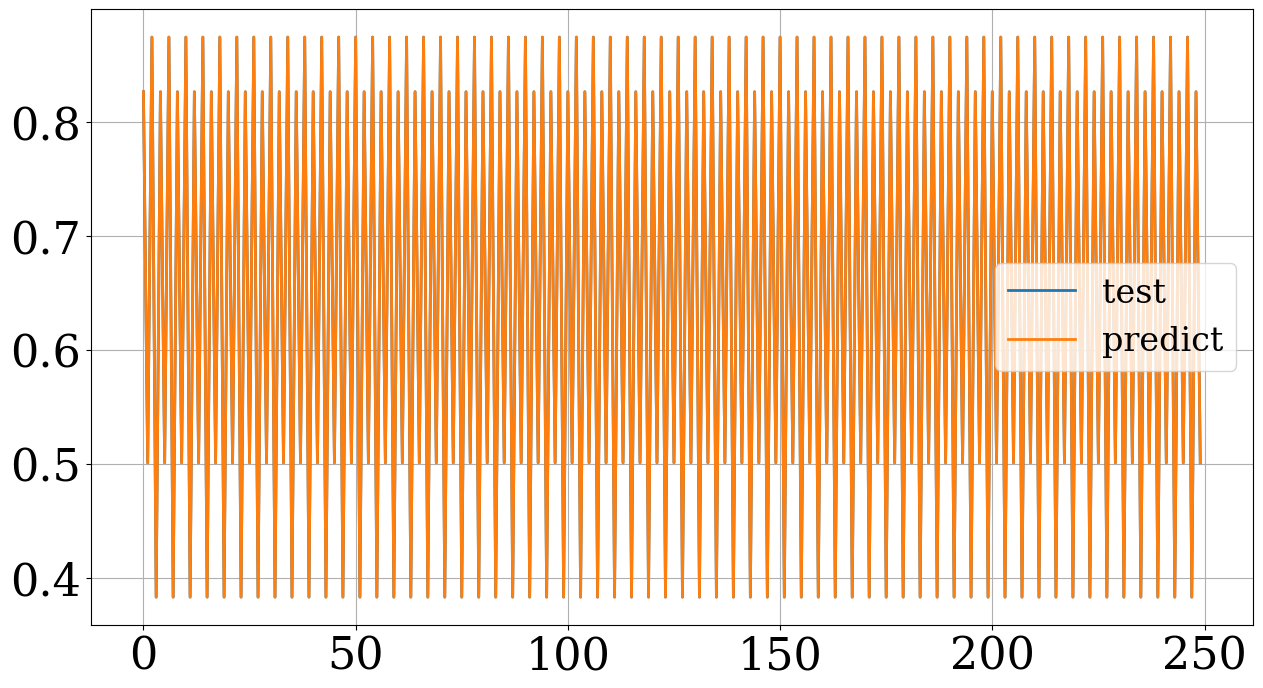

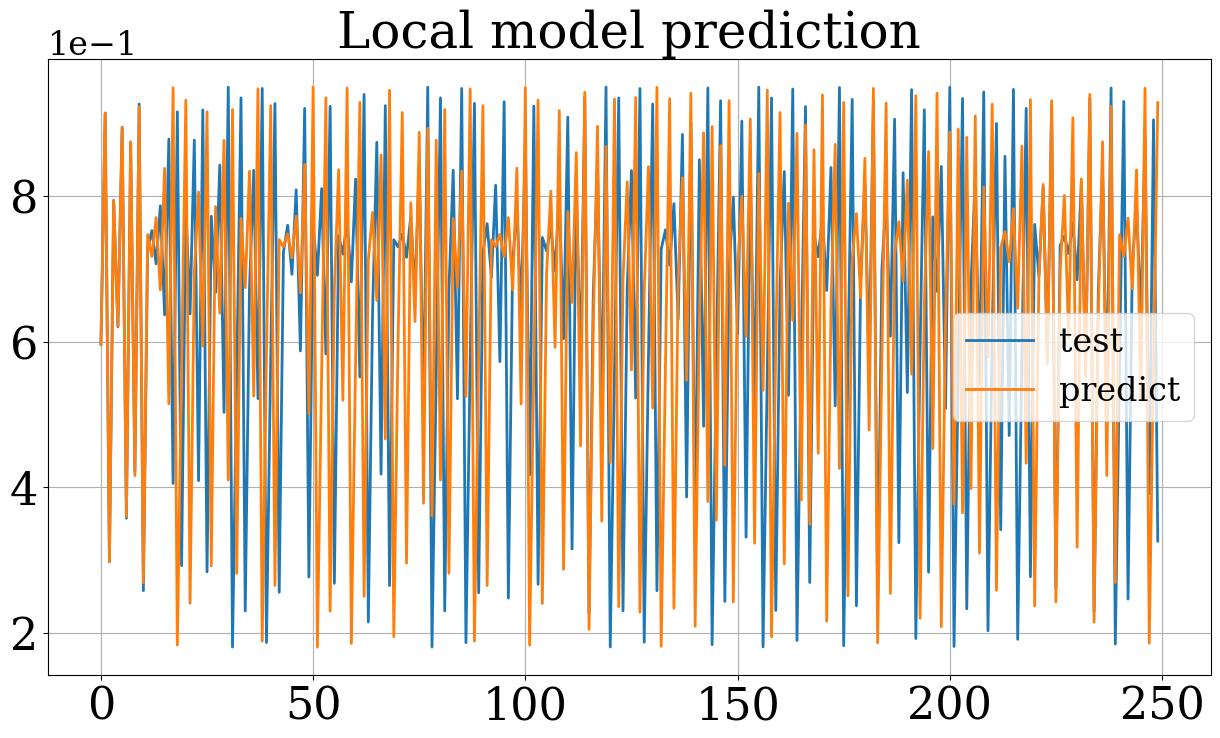

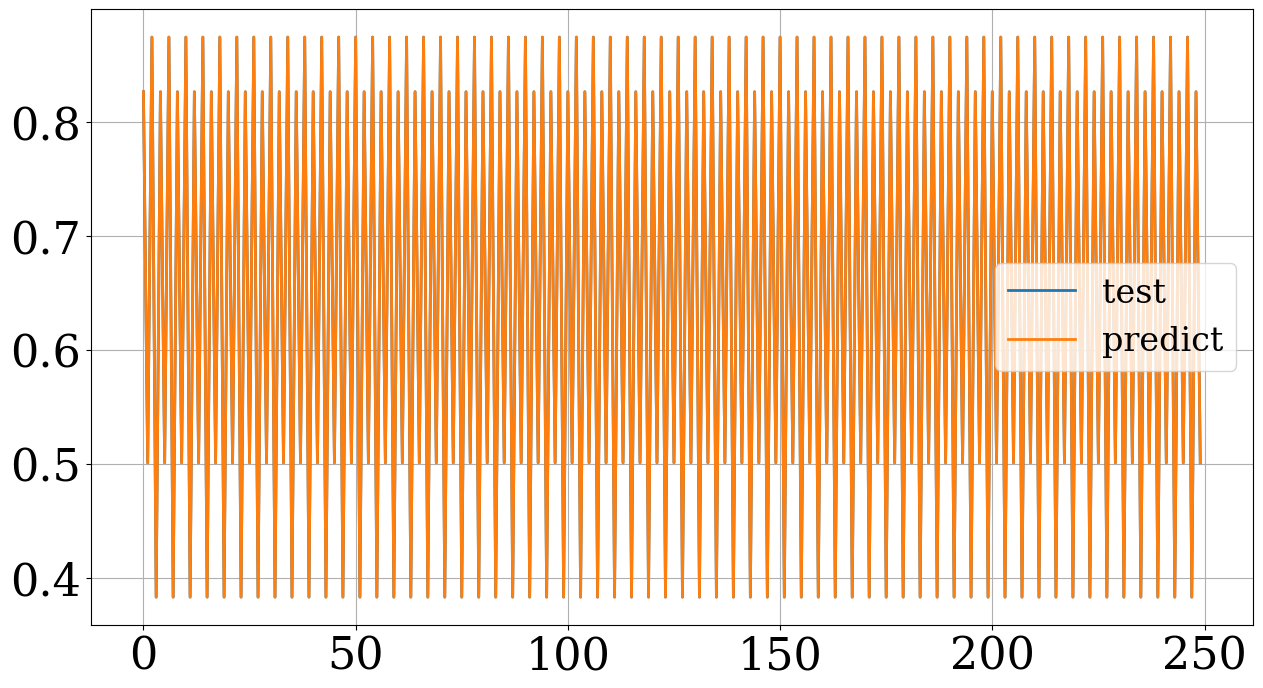

In [92]:
loc_multimodels_nocov[250][0].plot_fit_pred()

In [93]:
test_preds = loc_multimodels_nocov[250][0].predict(h)

In [94]:
print(np.mean(np.abs(test_preds - test_ts), axis=0))
print(np.mean(np.mean(np.abs(test_preds - test_ts), axis=0)))

[2.14701555e-01 3.48832074e-16]
0.1073507775111944


## Ridge

In [17]:
loc_multimodels_ridge = {h_i: [LocalMultiModel(L, loc_model, Ridge(), 'scm').fit(train_ts, h=h_i)] for h_i in h_range}

g: 62, f: 62
g: 83, f: 83
g: 125, f: 125
g: 250, f: 250
g: 350, f: 350
g: 450, f: 450
g: 550, f: 550
g: 650, f: 650
g: 750, f: 750
g: 850, f: 850


In [18]:
for key in loc_multimodels_ridge:
    output = loc_multimodels_ridge[key][-1].F_quality()
    loc_multimodels_ridge[key].append(output)

In [19]:
multi_ridge_mean_train_mse = []
local_ridge_mean_train_mse = []
multi_ridge_mean_test_mse = []
local_ridge_mean_test_mse = []

for key in loc_multimodels_ridge:
    multi_ridge_mean_train_mse.append(loc_multimodels_ridge[key][1]['train_mean'][0])
    local_ridge_mean_train_mse.append(loc_multimodels_ridge[key][1]['local_train_mean'][0])
    multi_ridge_mean_test_mse.append(loc_multimodels_ridge[key][1]['test_mean'][0])
    local_ridge_mean_test_mse.append(loc_multimodels_ridge[key][1]['local_test_mean'][0])

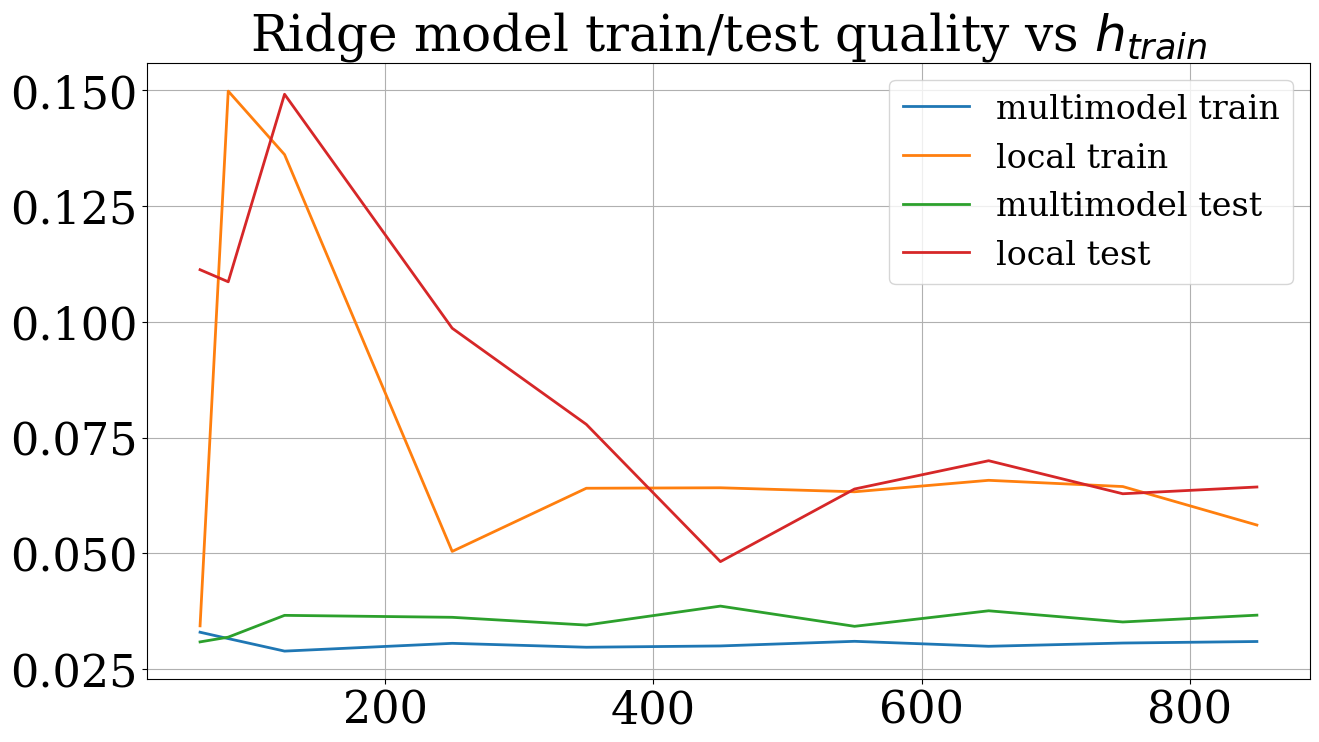

In [20]:
with EnableJournalStylePlotting():
    fig, ax = plt.subplots(figsize=(15, 8))

    ax.plot(h_range, multi_ridge_mean_train_mse, label='multimodel train')
    ax.plot(h_range, local_ridge_mean_train_mse, label='local train')
    ax.plot(h_range, multi_ridge_mean_test_mse, label='multimodel test')
    ax.plot(h_range, local_ridge_mean_test_mse, label='local test')

    ax.grid(True)
    ax.legend()

    ax.tick_params(axis='x', labelsize=32)
    ax.tick_params(axis='y', labelsize=32)
    #ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
    ax.set_title(r"Ridge model train/test quality vs $h_{train}$")
    
    plt.show()

In [22]:
params_ridge = loc_multimodels_ridge[250][0].F_model.coef_
print(params_ridge)

[[-0.01484084 -0.0287775   0.03044331  0.00943364  0.03516339]
 [-0.00232517  0.18585516  0.00976716  0.00128365  0.01033323]]


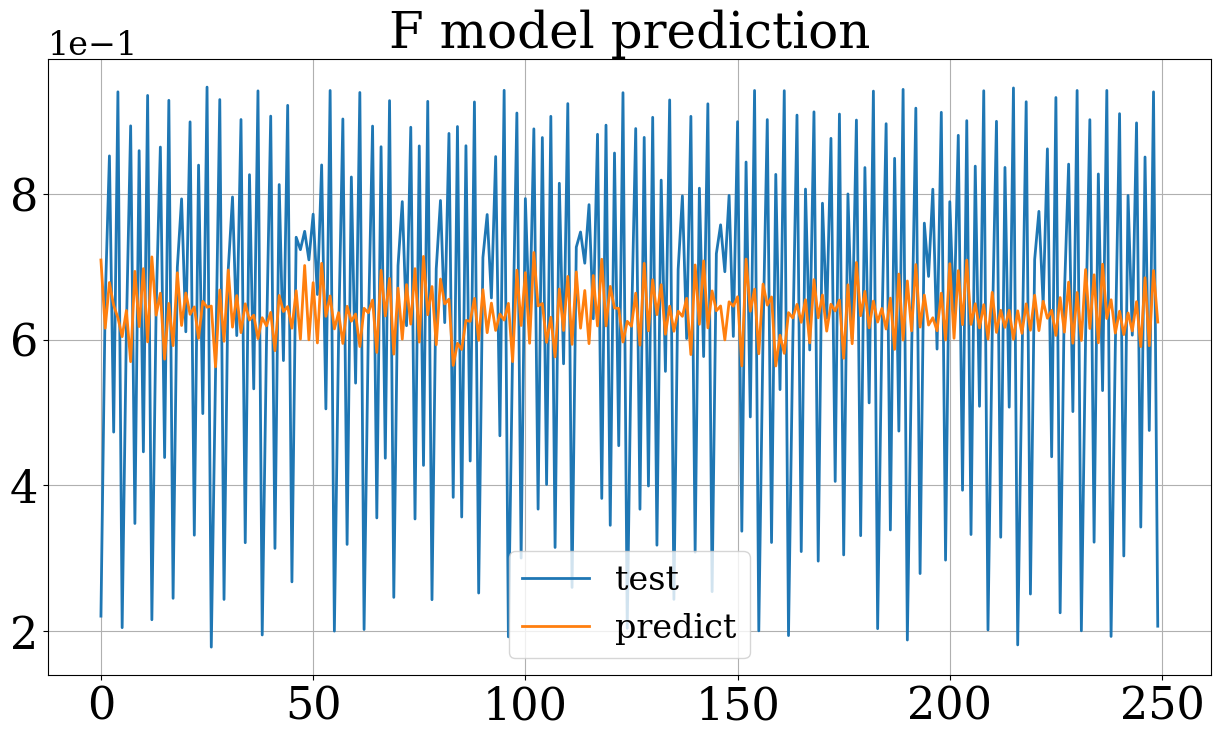

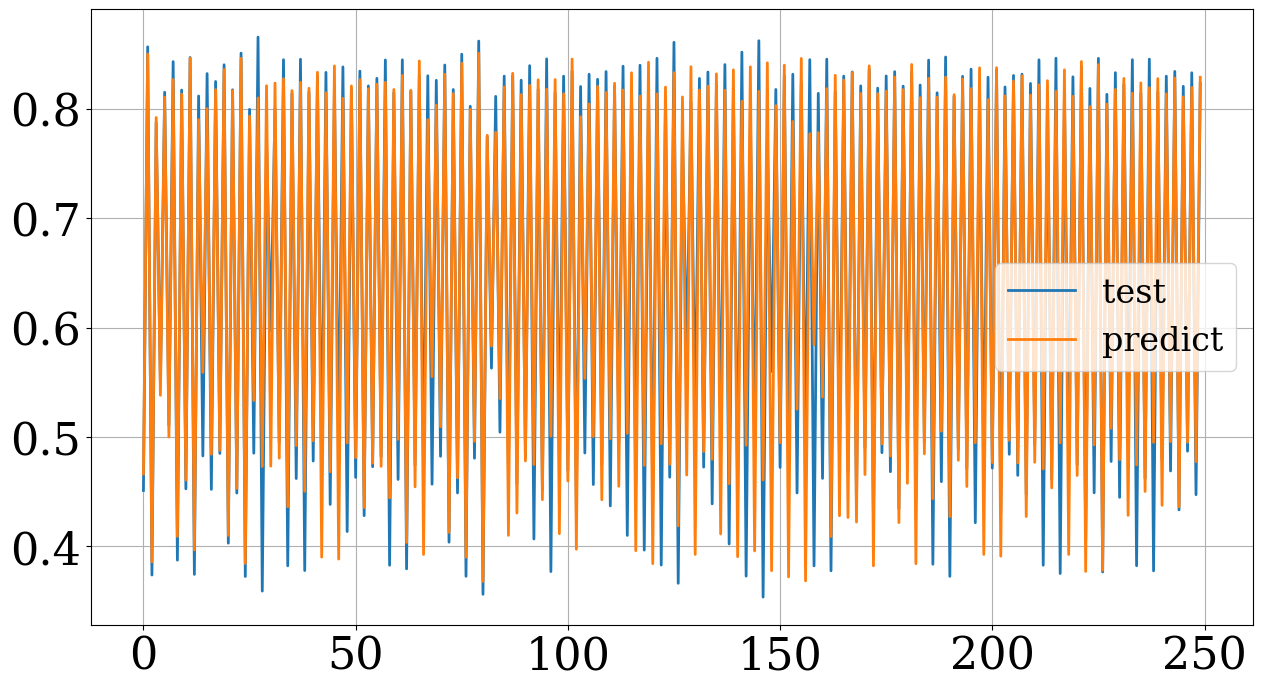

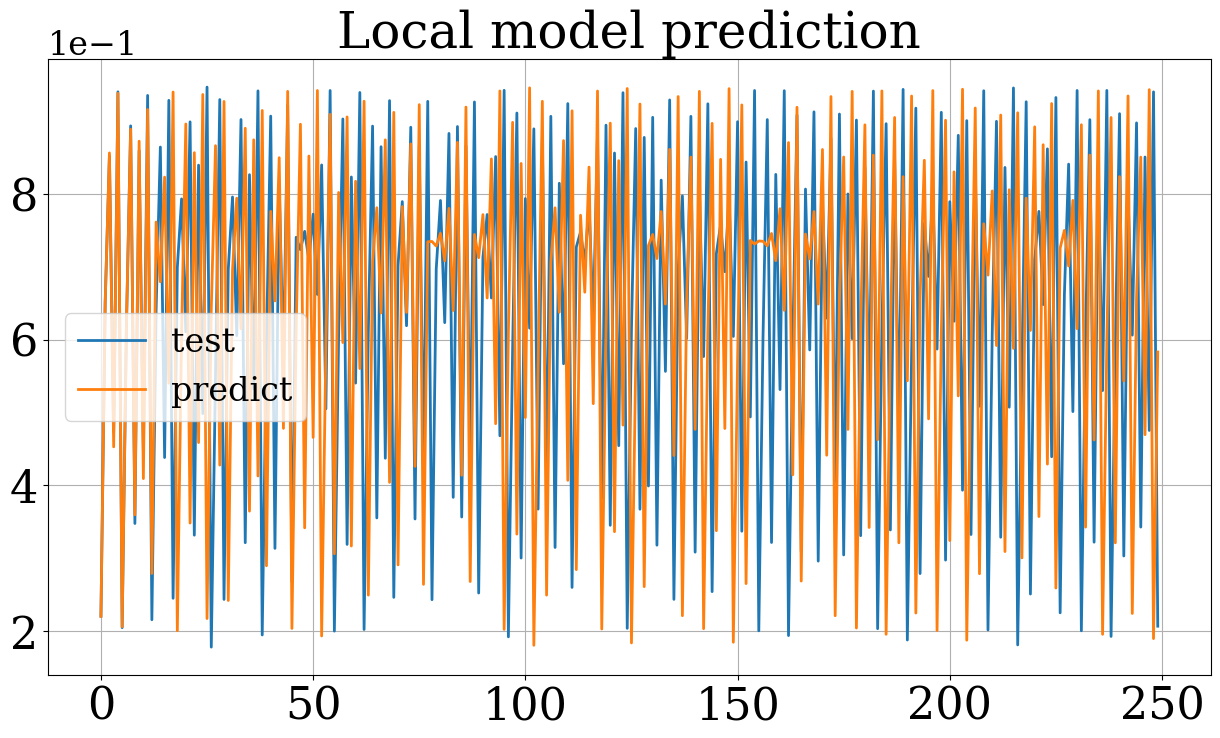

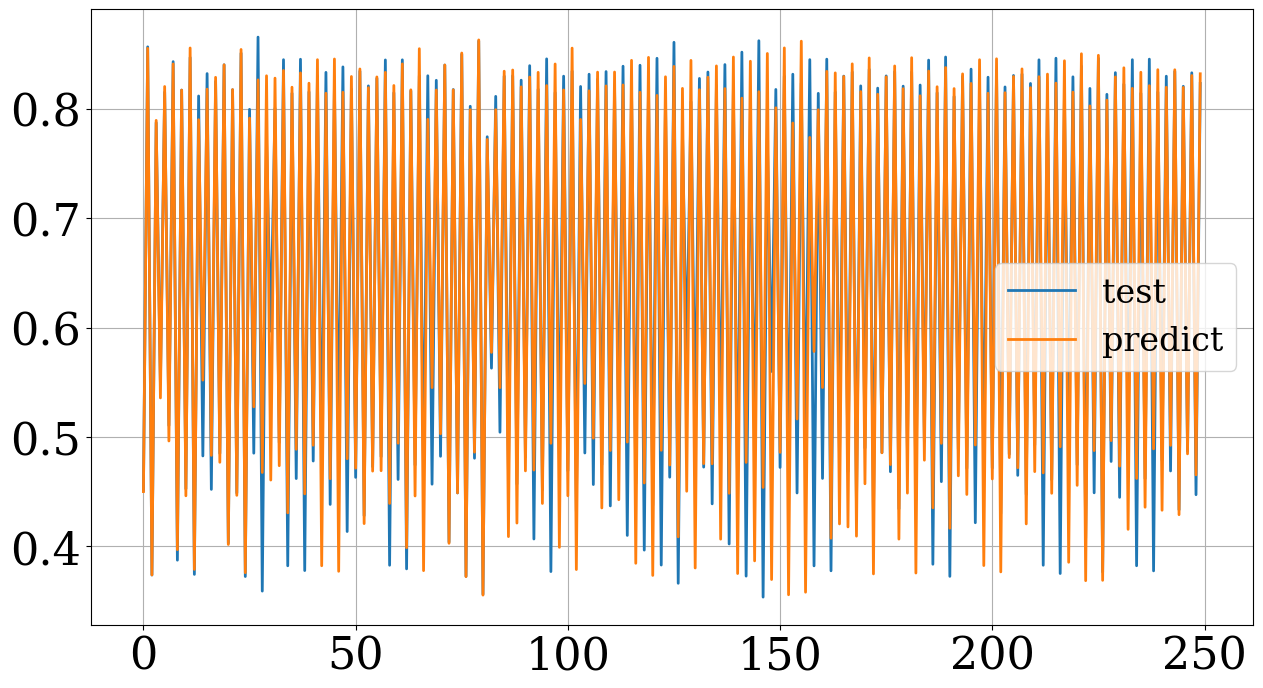

In [24]:
loc_multimodels_ridge[250][0].plot_fit_pred()

In [25]:
test_preds_ridge = loc_multimodels_ridge[250][0].predict(h)

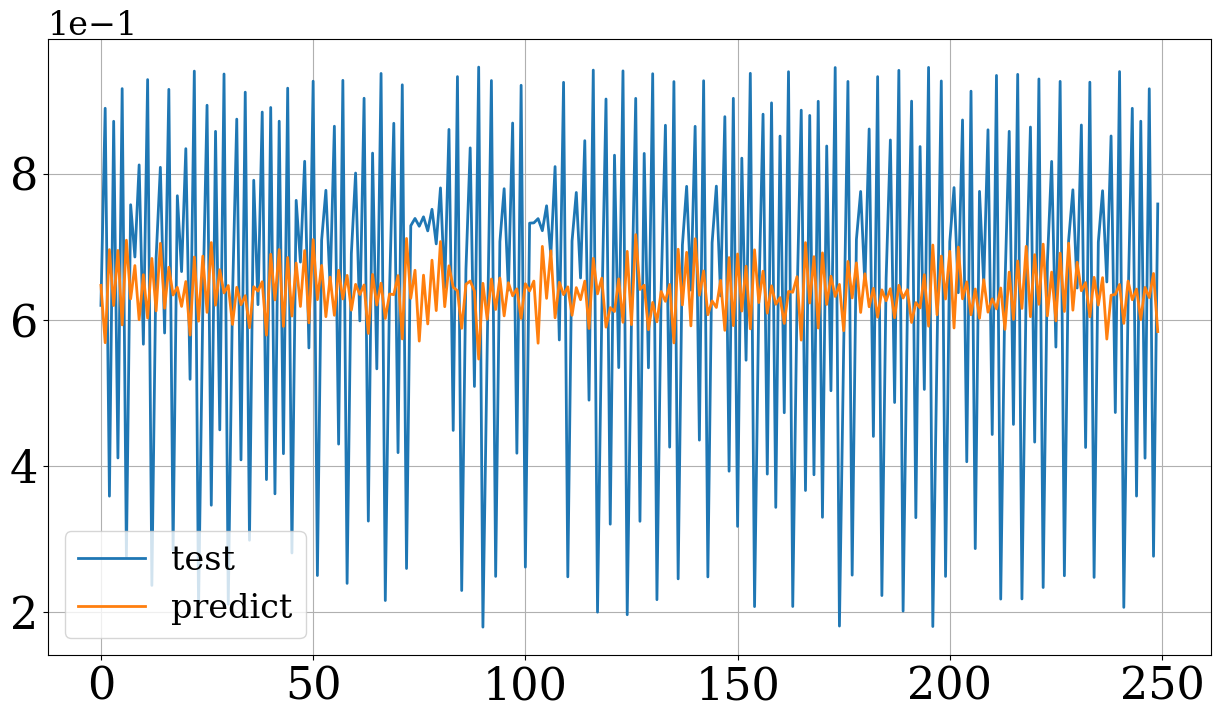

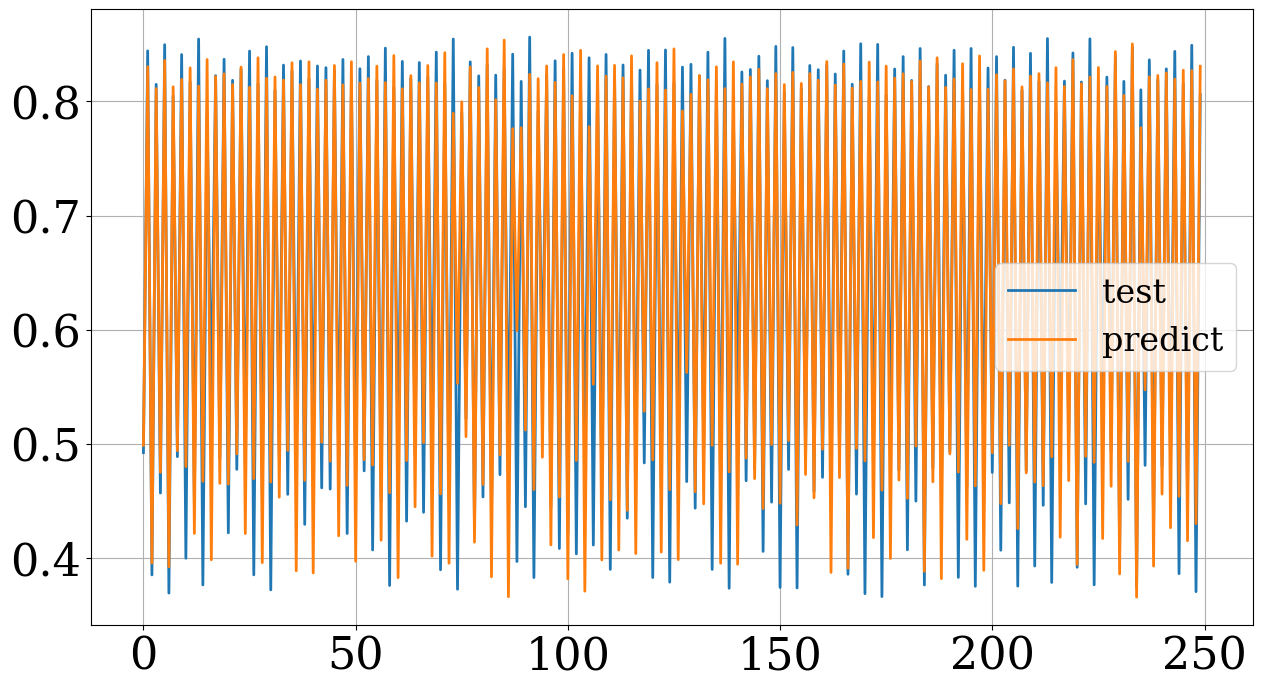

In [26]:
for i in range(test_ts.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(15, 8))

        ax.plot(test_ts.T[i], label='test')
        ax.plot(test_preds_ridge.T[i], label='predict')

        ax.grid(True)
        ax.legend()

        ax.tick_params(axis='x', labelsize=32)
        ax.tick_params(axis='y', labelsize=32)
        if i == 0:
            ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
            # ax.set_title('F model prediction')

plt.show()

In [27]:
print(np.mean((test_preds_ridge - test_ts) ** 2, axis=0))

[0.06146232 0.00254876]


## Lasso

In [43]:
loc_multimodels_lasso = {h_i: [LocalMultiModel(L, loc_model, Lasso(alpha=0.001), 'scm').fit(train_ts, h=h_i)] for h_i in h_range}

g: 62, f: 62
g: 83, f: 83
g: 125, f: 125
g: 250, f: 250
g: 350, f: 350
g: 450, f: 450
g: 550, f: 550
g: 650, f: 650
g: 750, f: 750
g: 850, f: 850


In [44]:
for key in loc_multimodels_lasso:
    output = loc_multimodels_lasso[key][-1].F_quality()
    loc_multimodels_lasso[key].append(output)


multi_lasso_mean_train_mse = []
local_lasso_mean_train_mse = []
multi_lasso_mean_test_mse = []
local_lasso_mean_test_mse = []

for key in loc_multimodels_lasso:
    multi_lasso_mean_train_mse.append(loc_multimodels_lasso[key][1]['train_mean'][0])
    local_lasso_mean_train_mse.append(loc_multimodels_lasso[key][1]['local_train_mean'][0])
    multi_lasso_mean_test_mse.append(loc_multimodels_lasso[key][1]['test_mean'][0])
    local_lasso_mean_test_mse.append(loc_multimodels_lasso[key][1]['local_test_mean'][0])

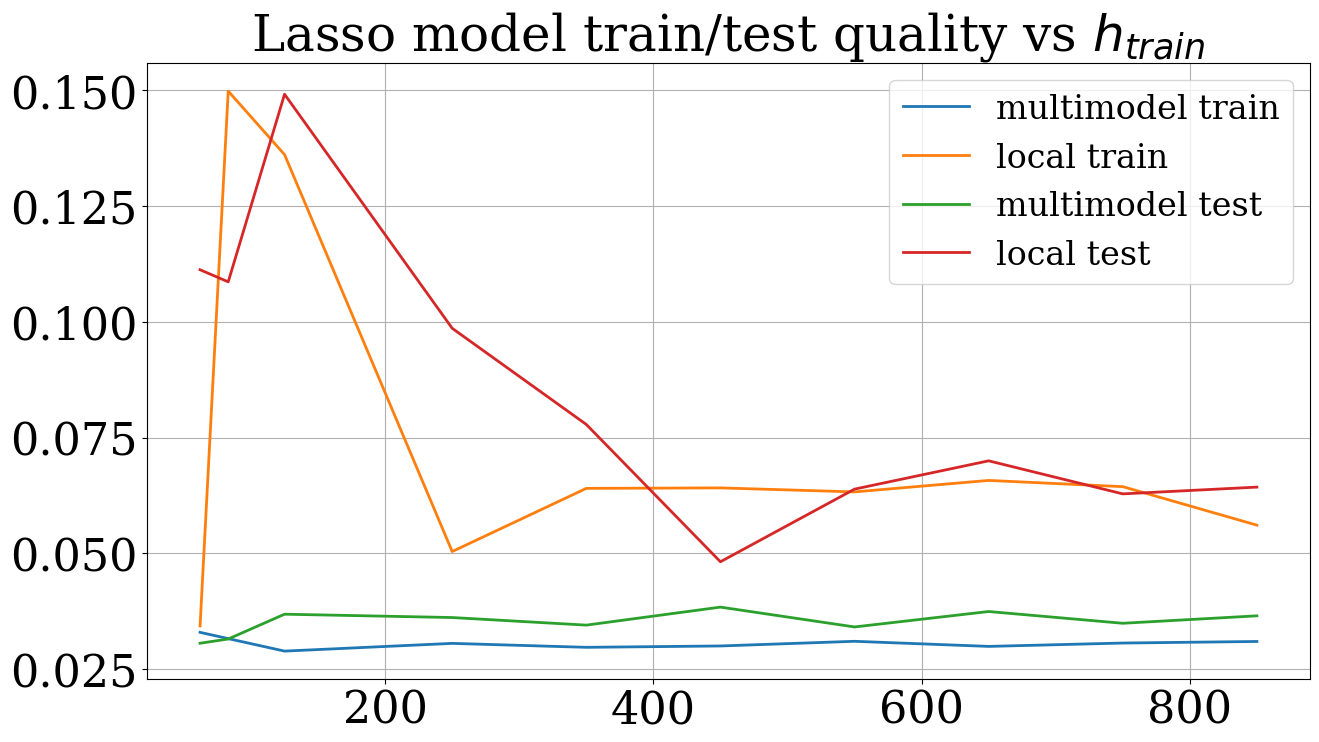

In [45]:
with EnableJournalStylePlotting():
    fig, ax = plt.subplots(figsize=(15, 8))

    ax.plot(h_range, multi_lasso_mean_train_mse, label='multimodel train')
    ax.plot(h_range, local_lasso_mean_train_mse, label='local train')
    ax.plot(h_range, multi_lasso_mean_test_mse, label='multimodel test')
    ax.plot(h_range, local_lasso_mean_test_mse, label='local test')

    ax.grid(True)
    ax.legend()

    ax.tick_params(axis='x', labelsize=32)
    ax.tick_params(axis='y', labelsize=32)
    #ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
    ax.set_title(r"Lasso model train/test quality vs $h_{train}$")
    
    plt.show()

In [47]:
params_lasso = loc_multimodels_lasso[550][0].F_model.coef_
print(params_lasso)

[[-0.00640689  0.01255718  0.00820756 -0.00290163  0.        ]
 [ 0.00104227  0.18554398  0.         -0.00079606  0.00166372]]
